_Disclaimer: This code is from a tutorial taken from [Vincent Tatan](https://towardsdatascience.com/in-12-minutes-stocks-analysis-with-pandas-and-scikit-learn-a8d8a7b50ee7)._

In [1]:
import pandas as pd
import datetime
import pandas_datareader.data as web
from pandas import Series, DataFrame

/Users/sameenislam/anaconda3/envs/fastai-cpu/lib/python3.6/site-packages/pandas_datareader/compat/__init__.py:7: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  from pandas.util.testing import assert_frame_equal


In [2]:
start = datetime.datetime(year=2010, month=1, day=1)
end = datetime.datetime(2017, 1, 11)

In [3]:
df = web.DataReader("AAPL", 'yahoo', start, end)
df.tail()

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2017-01-05,116.860001,115.809998,115.919998,116.610001,22193600.0,111.129562
2017-01-06,118.160004,116.470001,116.779999,117.910004,31751900.0,112.368469
2017-01-09,119.430000,117.940002,117.949997,118.989998,33561900.0,113.397697
2017-01-10,119.379997,118.300003,118.769997,119.110001,24462100.0,113.512070
2017-01-11,119.930000,118.599998,118.739998,119.750000,27588600.0,114.121986


### Exploring Rolling Mean and Return Rate of Stocks

In [4]:
close_px = df['Adj Close']
mavg = close_px.rolling(window=100).mean()

In [5]:
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib import style

In [6]:
import matplotlib as mpl
mpl.rc('figure', figsize=(8, 7))
mpl.__version__

'2.2.3'

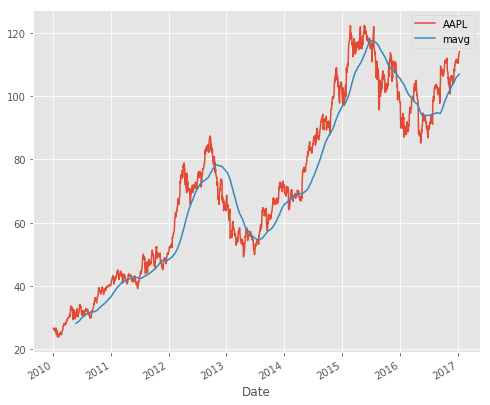

In [7]:
style.use('ggplot')

close_px.plot(label='AAPL')
mavg.plot(label='mavg')
plt.legend()

#### Return Deviation - determine risk & return

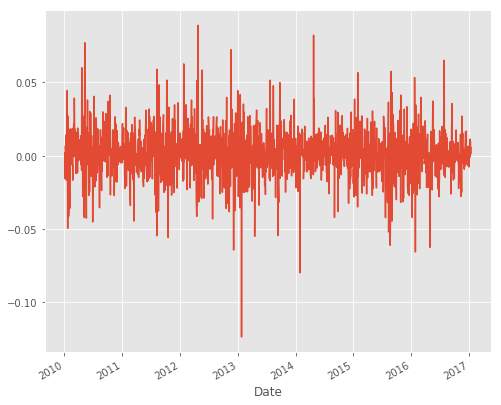

In [8]:
rets = close_px / close_px.shift(1) - 1
rets.plot(label='return')

### Analysing competitor's stocks

In [9]:
dfcomp = web.DataReader(['AAPL', 'GE', 'GOOG', 'IBM', 'MSFT'], 'yahoo', start=start, 
                        end=end)['Adj Close']
dfcomp.tail()

Symbols,AAPL,GE,GOOG,IBM,MSFT
Date,,,,,
2017-01-05,111.129562,27.885809,794.020020,146.729950,59.029503
2017-01-06,112.368469,27.965435,806.150024,147.451843,59.541157
2017-01-09,113.397697,27.832729,806.650024,145.816681,59.351658
2017-01-10,113.512070,27.753109,804.789978,143.964111,59.332706
2017-01-11,114.121986,27.841576,807.909973,145.903641,59.872780


#### Correlation analysis - Does one competitor affect another?

In [10]:
retscomp = dfcomp.pct_change()
corr = retscomp.corr()

Text(0,0.5,'Returns GE')

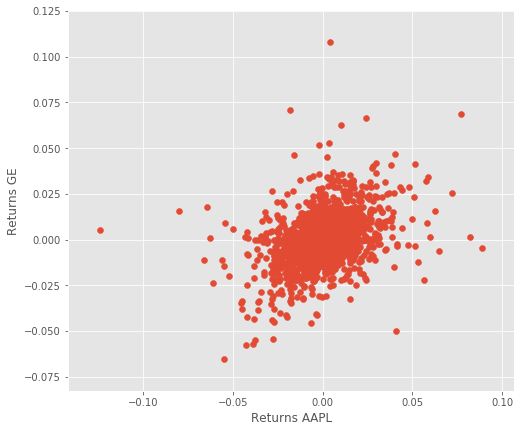

In [11]:
plt.scatter(retscomp.AAPL, retscomp.GE)
plt.xlabel('Returns AAPL')
plt.ylabel('Returns GE')

Plot of AAPL and GE return distribution. Obvs: Higher AAPL return results in higher GE returns.

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x114f44c18>,
      dtype=object)

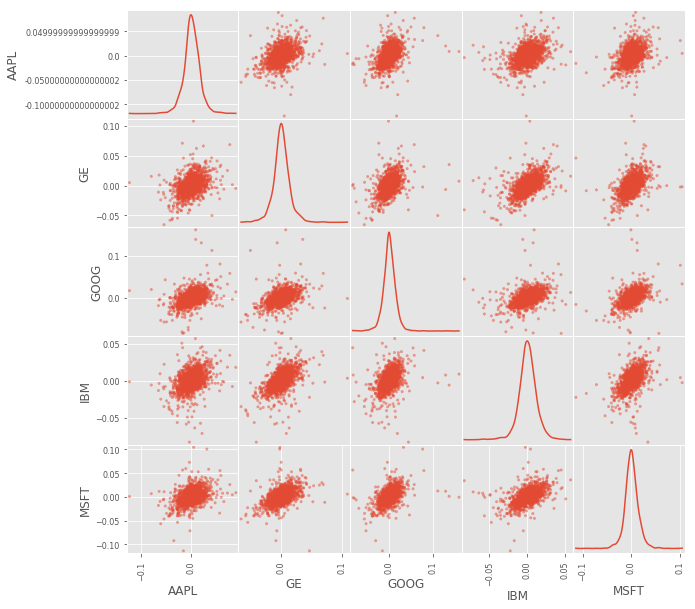

In [12]:
pd.plotting.scatter_matrix(retscomp, diagonal='kde', figsize=(10, 10))

Using heatmaps, we can visualise correlation ranges among competing stocks. Lighter color means higher correlation between stocks.

([<matplotlib.axis.YTick at 0x1a17401ef0>,
 <a list of 5 Text yticklabel objects>)

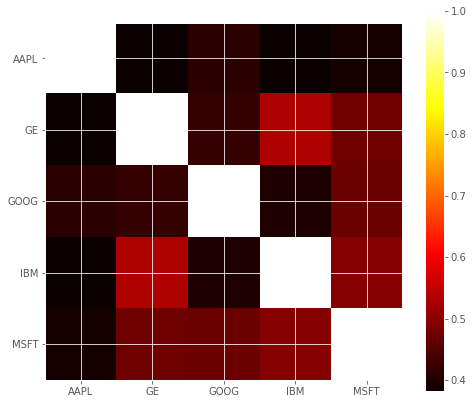

In [13]:
plt.imshow(corr, cmap='hot', interpolation='none')
plt.colorbar()
plt.xticks( range(len(corr)), corr.columns )
plt.yticks( range(len(corr)), corr.columns )

### Stocks returns rate & risk

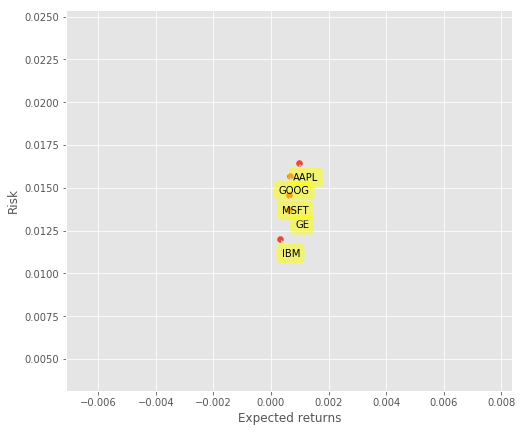

In [14]:
plt.scatter(retscomp.mean(), retscomp.std())
plt.xlabel('Expected returns')
plt.ylabel('Risk')
for label, x, y in zip(retscomp.columns, retscomp.mean(), retscomp.std()):
    plt.annotate(
        label,
        xy = (x, y), xytext = (20, -20),
        textcoords = 'offset points', ha = 'right', va = 'bottom',
        bbox = dict(boxstyle = 'round,pad=0.5', fc = 'yellow', alpha = 0.5),
        arrowprops = dict(arrowstyle = '->', connectionstyle = 'arc3,rad=0'))

### Stock price prediction

In [15]:
dfreg = df.loc[:, ['Adj Close', 'Volume']]
dfreg['HL_PCT'] = (df['High'] - df['Low']) / df['Close'] * 100.0
dfreg['PCT_change'] = (df['Close'] - df['Open']) / df['Open'] * 100.0

In [17]:
import math
dfreg.fillna(value=-99999, inplace=True)
forecast_out = int(math.ceil(0.01 * len(dfreg)))

In [19]:
import numpy as np
forecast_col = 'Adj Close'
dfreg['label'] = dfreg[forecast_col].shift(-forecast_out)
X = np.array(dfreg.drop(['label'], 1))

In [23]:
import sklearn.preprocessing as preprocessing
X = preprocessing.scale(X)

In [24]:
X_lately = X[-forecast_out:]
X = X[:-forecast_out]

In [25]:
y = np.array(dfreg['label'])
y = y[:-forecast_out]

### Model generation

In [27]:
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor

from sklearn.linear_model import Ridge
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline

In [29]:
def split_vals(a, n): return a[:n].copy(), a[n:].copy()

In [51]:
n_valid = 525
n_trn = len(X)-n_valid

X_train, X_valid = split_vals(X, n_trn)
y_train, y_valid = split_vals(y, n_trn)

X_train.shape, y_train.shape, X_valid.shape

((1226, 4), (1226,), (525, 4))

In [52]:
clfreg =  LinearRegression(n_jobs=-1)
clfreg.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=-1, normalize=False)

In [53]:
clfpoly2 = make_pipeline(PolynomialFeatures(2), Ridge())
clfpoly2.fit(X_train, y_train)

Pipeline(memory=None,
         steps=[('polynomialfeatures',
                 PolynomialFeatures(degree=2, include_bias=True,
                                    interaction_only=False, order='C')),
                ('ridge',
                 Ridge(alpha=1.0, copy_X=True, fit_intercept=True,
                       max_iter=None, normalize=False, random_state=None,
                       solver='auto', tol=0.001))],
         verbose=False)

In [54]:
clfpoly3 = make_pipeline(PolynomialFeatures(3), Ridge())
clfpoly3.fit(X_train, y_train)

Pipeline(memory=None,
         steps=[('polynomialfeatures',
                 PolynomialFeatures(degree=3, include_bias=True,
                                    interaction_only=False, order='C')),
                ('ridge',
                 Ridge(alpha=1.0, copy_X=True, fit_intercept=True,
                       max_iter=None, normalize=False, random_state=None,
                       solver='auto', tol=0.001))],
         verbose=False)

In [55]:
clfknn = KNeighborsRegressor(n_neighbors=2)
clfknn.fit(X_train, y_train)

KNeighborsRegressor(algorithm='auto', leaf_size=30, metric='minkowski',
                    metric_params=None, n_jobs=None, n_neighbors=2, p=2,
                    weights='uniform')

In [69]:
confidencereg = clfreg.score(X_valid, y_valid)
confidencepoly2 = clfpoly2.score(X_valid, y_valid)
confidencepoly3 = clfpoly3.score(X_valid, y_valid)
confidenceknn = clfknn.score(X_valid, y_valid)
[confidencereg, confidencepoly2, confidencepoly3, confidenceknn]

[0.4713306015998503,
 0.3825879412899464,
 0.06005908631580271,
 -0.45087627691443255]

In [72]:
forecast_set = clfpoly3.predict(X_lately)
dfreg['Forecast'] = np.nan
forecast_set

array([113.22320598, 110.42779319, 118.84839636, 117.73504269,
       116.76604086, 115.77223555, 120.36115112, 120.79965124,
       120.27897217, 118.92154727, 116.64254166, 117.63056846,
       116.76810514, 118.51867857, 119.42037728, 119.39759457,
       119.80811795, 121.07280201])

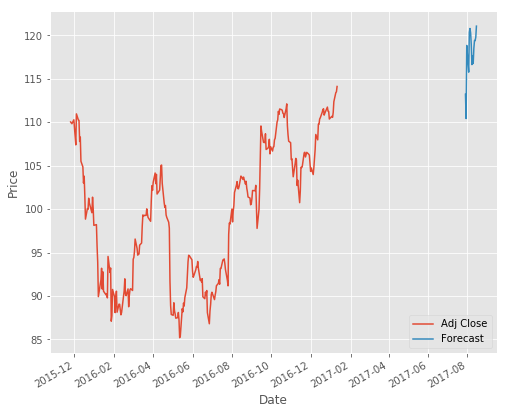

In [73]:
last_date = dfreg.iloc[-1].name
last_unix = last_date
next_unix = last_unix + datetime.timedelta(days=1)

for i in forecast_set:
    next_date = next_unix
    next_unix += datetime.timedelta(days=1)
    dfreg.loc[next_date] = [np.nan for _ in range(len(dfreg.columns) -1)] + [i]

dfreg['Adj Close'].tail(500).plot()
dfreg['Forecast'].tail(500).plot()
plt.legend(loc=4)
plt.xlabel('Date')
plt.ylabel('Price')
plt.show()